In [1]:
from tqdm import tqdm

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from utils.property import ICESAT2Properties

plt.rcParams["font.family"] = ["Times New Roman","SimHei"]

# 读取数据
df = pd.read_csv("dataset_train.csv")

# 特征和标签
X_cols = [
    "Height (m MSL)",
    "B1",
    "B2",
    "B3",
    "B4",
    "B5",
]
Y_col = "real_height"

# 取出特征和标签
data_X = df[X_cols].values
data_Y = df[Y_col].values

In [16]:
batch_size=16
acc_diff = 0.1
num_epochs = 50
lr = 0.0001

In [17]:
scaler = StandardScaler()


def normalize(data):
    data_no_height = X_cols.copy()
    data_no_height.remove("Height (m MSL)")
    data_X_scaled = df[data_no_height].values
    scaled_part = scaler.fit_transform(data_X_scaled)
    # 拼接未归一化的Height (m MSL)和归一化后的其他特征
    height_col = df[["Height (m MSL)"]].values
    # 保证顺序一致
    if X_cols[0] == "Height (m MSL)":
        reslut = np.concatenate([height_col, scaled_part], axis=1)
    else:
        # 若Height (m MSL)不在首位，需按X_cols顺序重组
        data_X_dict = {"Height (m MSL)": height_col}
        for i, col in enumerate(data_no_height):
            data_X_dict[col] = scaled_part[:, i:i+1]
        reslut = np.concatenate([data_X_dict[col] for col in X_cols], axis=1)

    return reslut

data_X = normalize(data_X) 

# 划分为训练集和测试集，确保不重合
X_train, X_test, y_train, y_test = train_test_split(
    data_X, data_Y, test_size=0.2, random_state=42, shuffle=True, stratify=None
)

# 检查GPU
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 转为Tensor并放到DEVICE
train_X = torch.tensor(X_train, dtype=torch.float32).to(DEVICE)
train_Y = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1).to(DEVICE)
test_X = torch.tensor(X_test, dtype=torch.float32).to(DEVICE)
test_Y = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1).to(DEVICE)

# 构建数据集和数据加载器
train_dataset = TensorDataset(train_X, train_Y)
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
test_dataset = TensorDataset(test_X, test_Y)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False)

In [18]:
class CNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        # self.conv = nn.Sequential(
        #     nn.Conv1d(1, 16, kernel_size=3, padding=1),
        #     nn.ReLU(),
        #     nn.Conv1d(16, 32, kernel_size=3, padding=1),
        #     nn.ReLU(),
        # )
        # self.fc = nn.Sequential(
        #     nn.Flatten(),
        #     nn.Linear(32 * input_dim, 16),
        #     nn.ReLU(),

        #     nn.Linear(16, 1)
        # )


        self.conv = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=3, padding=1),
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.MaxPool1d(kernel_size=2)
        )   
        # 计算池化后特征长度
        pooled_length = input_dim
        pooled_length = pooled_length // 2  # 第一次MaxPool1d
        pooled_length = pooled_length // 2  # 第二次MaxPool1d
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * pooled_length, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )

    def forward(self, x):
        # x shape: [batch, features] -> [batch, 1, features]
        x = x.unsqueeze(1)
        x = self.conv(x)
        x = self.fc(x)
        return x

Epoch 5/50, Loss: 0.9603, Train Acc: 0.0105, Test Acc: 0.0833
Epoch 10/50, Loss: 0.6618, Train Acc: 0.0316, Test Acc: 0.0417
Epoch 15/50, Loss: 0.4114, Train Acc: 0.0421, Test Acc: 0.0000
Epoch 20/50, Loss: 0.2161, Train Acc: 0.1684, Test Acc: 0.0833
Epoch 25/50, Loss: 0.1079, Train Acc: 0.2526, Test Acc: 0.1667
Epoch 30/50, Loss: 0.0717, Train Acc: 0.2632, Test Acc: 0.3750
Epoch 35/50, Loss: 0.0627, Train Acc: 0.3158, Test Acc: 0.5000
Epoch 40/50, Loss: 0.0575, Train Acc: 0.3579, Test Acc: 0.5000
Epoch 45/50, Loss: 0.0520, Train Acc: 0.3895, Test Acc: 0.5000
Epoch 50/50, Loss: 0.0477, Train Acc: 0.4000, Test Acc: 0.5000


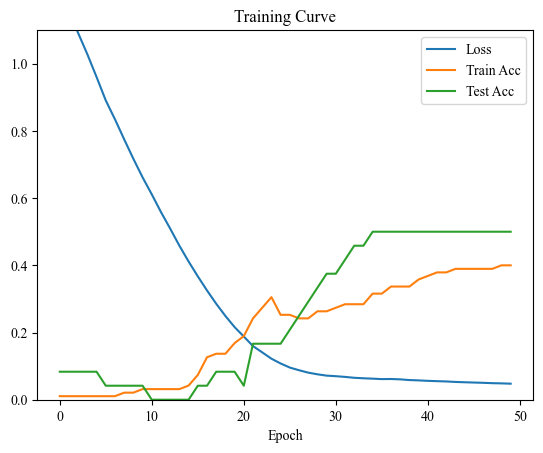

In [19]:
model = CNN(input_dim=train_X.shape[1]).to(DEVICE)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# 用于保存每个epoch的loss和acc
loss_list = []
train_acc_list = []
test_acc_list = []

for epoch in range(num_epochs):
    epoch_loss = 0
    correct_train = 0
    total_train = 0
    for batch_X, batch_Y in train_loader:
        pred = model(batch_X)
        loss = criterion(pred, batch_Y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        correct_train += (torch.abs(pred - batch_Y) <= acc_diff).sum().item()
        total_train += batch_Y.size(0)
    train_acc = correct_train / total_train

    # 计算测试集acc
    model.eval()
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for batch_X, batch_Y in test_loader:
            pred = model(batch_X)
            correct_test += (torch.abs(pred - batch_Y) <= acc_diff).sum().item()
            total_test += batch_Y.size(0)
    test_acc = correct_test / total_test
    model.train()

    # 保存loss和acc
    loss_list.append(epoch_loss / len(train_loader))
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)

    if (epoch + 1) % (num_epochs / 10) == 0 or epoch == num_epochs - 1:
        loss = epoch_loss / len(train_loader)
        tqdm.write(
            f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}"
        )

# 画出loss和acc曲线
plt.figure()
plt.title('Training Curve')
plt.plot(loss_list, label='Loss')
plt.plot(train_acc_list, label='Train Acc')
plt.plot(test_acc_list, label='Test Acc')
plt.ylim(0, 1.1)
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [20]:
# 特征重要性分析
from itertools import chain


with torch.no_grad():
    # 取第一个全连接层的权重（Linear(32 * input_dim, 16)）
    weights = model.fc[1].weight.abs().mean(dim=0).cpu().numpy()
    feature_importance = list(zip(X_cols, weights))
    feature_importance.sort(key=lambda x: x[1], reverse=True)
    print("Feature importance (descending):")
    for name, score in feature_importance:
        print(f"{name}: {score:.4f}")
print("#########################")

# 测试集评估
with torch.no_grad():
    model.eval()
    test_loss = 0
    for batch_X, batch_Y in test_loader:
        pred = model(batch_X)
        loss = criterion(pred, batch_Y)
        test_loss += loss.item()
    test_loss /= len(test_loader)
    print(f"Test Loss: {test_loss:.4f}")
    model.train()
print(f"Final: Train Acc: {train_acc_list[-1]:.4f}, Test Acc: {test_acc_list[-1]:.4f}")

print("#########################")

# 计算平均误差
def get_error(loader):
    with torch.no_grad():
        model.eval()
        all_preds = []
        all_labels = []
        for batch_X, batch_Y in loader:
            pred = model(batch_X)
            all_preds.append(pred.cpu().numpy())
            all_labels.append(batch_Y.cpu().numpy())
        all_preds = np.concatenate(all_preds, axis=0)
        all_labels = np.concatenate(all_labels, axis=0)
        return np.mean(np.abs(all_preds - all_labels))


test_mean_error = get_error(test_loader)
print(f"Mean Absolute Error on Test Set: {test_mean_error:.4f}")

train_mean_error = get_error(train_loader)
print(f"Mean Absolute Error on Train Set: {train_mean_error:.4f}")

all_mean_error = get_error(
    chain(train_loader, test_loader) 
)
print(f"Mean Absolute Error on All Data: {all_mean_error:.4f}")

print("#########################")

Feature importance (descending):
B4: 0.0756
B5: 0.0747
B1: 0.0657
B3: 0.0637
Height (m MSL): 0.0599
B2: 0.0466
#########################
Test Loss: 0.0399
Final: Train Acc: 0.4000, Test Acc: 0.5000
#########################
Mean Absolute Error on Test Set: 0.1496
Mean Absolute Error on Train Set: 0.1561
Mean Absolute Error on All Data: 0.1548
#########################


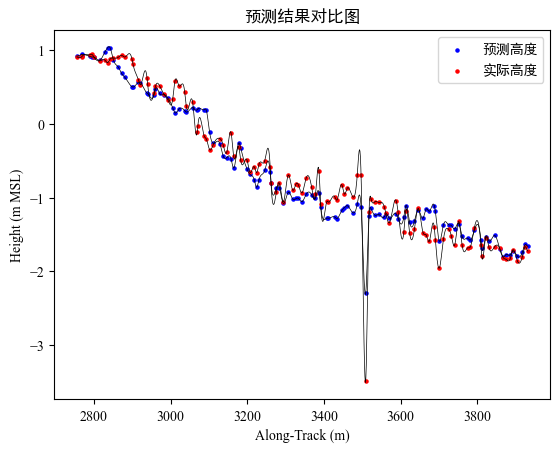

In [21]:
from scipy.interpolate import make_interp_spline

data_X = df[X_cols].values

data_X = normalize(data_X)
X = torch.tensor(data_X, dtype=torch.float32).to(DEVICE)

model.eval()
with torch.no_grad():
    # predictions = model(test_X).cpu().numpy().flatten()
    predictions = model(X).cpu().numpy().flatten()

fig, ax = plt.subplots()
plt.title("预测结果对比图")
plt.xlabel(ICESAT2Properties.AlongTrack.value)
plt.ylabel(ICESAT2Properties.Height_MSL.value)
ax.scatter(
    df[ICESAT2Properties.AlongTrack.value].values,
    predictions,
    label="预测高度",
    color="blue",
    s=5,
)
ax.scatter(
    df[ICESAT2Properties.AlongTrack.value].values,
    data_Y,
    label="实际高度",
    color="red",
    s=5,
)

# 插值曲线
interpolations: int = 1000
k: int = 3
bc_type: str = "clamped"
x_lable = ICESAT2Properties.AlongTrack.value

y = predictions
l = np.linspace(df[x_lable].min(), df[x_lable].max(), interpolations)
interpolation = make_interp_spline(df[x_lable], y, k=k, bc_type=bc_type)
y_hat = interpolation(l)
# 粉色
ax.plot(l, y_hat, color="black", linewidth=0.5)

y = data_Y
l = np.linspace(df[x_lable].min(), df[x_lable].max(), interpolations)
interpolation = make_interp_spline(df[x_lable], y, k=k, bc_type=bc_type)
y_hat = interpolation(l)
# 粉色
ax.plot(l, y_hat, color="black", linewidth=0.5)


plt.legend()
plt.show()

In [22]:
save = input("Save results to CNN.txt? (y/[n]): ")
if save.lower() == 'y':
    with open("CNN.txt", "w", encoding="utf-8") as f:
        f.write("Feature importance (descending):\n")
        for name, score in feature_importance:
            f.write(f"{name}: {score:.4f}\n")
        f.write("#########################")
        f.write(f"Final: Train Acc: {train_acc_list[-1]:.4f}, Test Acc: {test_acc_list[-1]:.4f}\n")
        f.write(f"Test Loss: {test_loss:.4f}\n")

        # 导出模型
        torch.save(model, "CNN_model.pth")
        f.write("Model saved as CNN_model.pth\n")

        scripted_model = torch.jit.script(model)
        scripted_model.save('CNN_model_scripted.pt')
    print("Results not saved.")

Results not saved.
